In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# EDA

## Tjonral

In [65]:
df_tjornal = pd.read_csv('tjornal.csv')

In [66]:
df_tjornal.head()

,article_url,article_time,article_head,article_content
0,https://tjournal.ru/u/274224-anatoliy-tihvinsk...,11.11.2019 17:33,ИСКУССТВЕННЫЙ ИНТЕЛЛЕКТ,Люди создали Искусственный Интеллект и открыл...
1,https://tjournal.ru/internet/131681-iskusstven...,18.12.2019 00:15,Искусственный интеллект,
2,https://tjournal.ru/tech/125621-iskusstvennyy-...,14.11.2019 04:41,Искусственный интеллект обучили копировать чуж...,
3,https://tjournal.ru/news/116219-vkontakte-vper...,13.09.2019 12:38,«ВКонтакте» впервые откроет научную лаборатори...,Кураторами лаборатории станут разработчики ко...
4,https://tjournal.ru/tech/131933-kazhdyy-iz-nih...,23.12.2019 11:35,Каждый из них играл за человечество: история п...,22 года развития ИИ в хронологии матчей – от ...


In [4]:
df_tjornal.shape

(420, 5)

In [7]:
sum(df_tjornal.article_content == ' ')

6

In [9]:
df_tjornal.drop_duplicates(subset=['article_url']).shape

(396, 6)

In [6]:
df_tjornal['article_length'] = df_tjornal.article_content.apply(lambda x: len(x) if x is not np.nan else np.nan)

In [34]:
row[1]

article_url        https://tjournal.ru/internet/131681-iskusstven...
article_time                     18.12.2019 00:15:06 (Europe/Moscow)
article_head                                 Искусственный интеллект
article_author                                       Интернет и мемы
article_content       Не понял прекол, переведите на питон  В язы...
article_length                                                   421
Name: 1, dtype: object

## Meduza

In [56]:
df_meduza = pd.read_csv('meduza.csv', parse_dates=['article_time'])

In [57]:
df_meduza.head()

,article_url,article_time,article_head,article_content
0,https://meduza.io/feature/2020/01/16/meduzoid-...,2020-01-16 16:55:00,«Медузоид» из сердца крысы и киборги из лягуша...,Исследователи из Университета Тафстса Новая ра...
1,https://meduza.io/slides/nevidimaya-klaviatura...,2020-01-11 16:03:00,"Невидимая клавиатура, крадущийся автомобиль-кр...",Каждый год на проходящей в Лас-Вегасе технолог...
2,https://meduza.io/slides/20-luchshih-russkih-i...,2020-01-03 06:42:00,20 лучших русских и иностранных книг за десяти...,«Медуза» продолжает подводить итоги десятилети...
3,https://meduza.io/slides/razve-mozhet-robot-na...,2019-12-30 12:16:00,Откуда искусственный интеллект берет вдохновен...,В 2018 году на аукционе Christieʼs Иногда гово...
4,https://meduza.io/episodes/2019/12/27/novye-ch...,2019-12-27 15:00:00,"Новые черные дыры, аэромобили и другие приятны...",Несколько месяцев подряд в подкасте «Так и буд...


In [58]:
df_meduza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 4 columns):
article_url        507 non-null object
article_time       507 non-null datetime64[ns]
article_head       507 non-null object
article_content    506 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 16.0+ KB


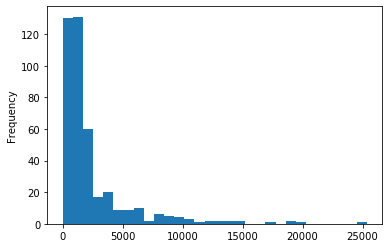

In [63]:
df.article_content.apply(lambda x: len(x)).plot(kind='hist', bins=30)

In [64]:
df.article_content.apply(lambda x: len(x)).describe()

count      420.000000
mean      2417.942857
std       3315.352135
min          1.000000
25%        680.500000
50%       1320.000000
75%       2386.250000
max      25352.000000
Name: article_content, dtype: float64

In [24]:
df_meduza.article_url.values[3]

'https://meduza.io/slides/razve-mozhet-robot-napisat-simfoniyu-sozdat-shedevr-kak-iskusstvennyy-intellekt-uchitsya-tvorit'

In [53]:
print(df_meduza.article_content.values[3])

В 2018 году на аукционе Christieʼs Иногда говорят, что музыку, изображения, тексты, которые создает искусственный интеллект, нельзя называть искусством, ведь они тиражируемые. Как если сравнить фабрику, на которой каждый день производятся тысячи стульев, и столяра, который делает стулья поштучно. Но эта аналогия не совсем верна. Нейросети, в отличие от станка, могут создавать уникальные штучные продукты. Просто они более производительны: то, на что у человека уходит несколько часов или дней, нейросеть может сделать за секунды. Нейронная сеть способна находить в массивах данных неочевидные закономерности. Например, если ее обучать на всем, что когда-либо написал определенный художник, она сможет выявлять свойственные его творчеству приемы лучше профессиональных искусствоведов. По тому же принципу можно научить нейросеть распознавать характерные черты не одного, а всех художников в мире. По мотивам увиденного она сможет создать уже что-то новое. Нейросеть может воссоздать все, чему ее об

In [17]:
df_meduza.head().T

,0,1,2,3,4
article_url,https://meduza.io/feature/2020/01/16/meduzoid-...,https://meduza.io/slides/nevidimaya-klaviatura...,https://meduza.io/slides/20-luchshih-russkih-i...,https://meduza.io/slides/razve-mozhet-robot-na...,https://meduza.io/episodes/2019/12/27/novye-ch...
article_time,"16:55, 16 января","16:03, 11 января","06:42, 3 января","12:16, 30 декабр","15:00, 27 декабр"
article_head,«Медузоид» из сердца крысы и киборги из лягуша...,"Невидимая клавиатура, крадущийся автомобиль-кр...",20 лучших русских и иностранных книг за десяти...,Откуда искусственный интеллект берет вдохновен...,"Новые черные дыры, аэромобили и другие приятны..."
article_content,Исследователи из Университета Тафстса Новая ра...,Каждый год на проходящей в Лас-Вегасе технолог...,«Медуза» продолжает подводить итоги десятилети...,В 2018 году на аукционе Christieʼs Иногда гово...,Несколько месяцев подряд в подкасте «Так и буд...


## N+1


In [68]:
df_nplus = pd.read_csv('nplus.csv', parse_dates=['article_time'])

In [73]:
df_nplus.head(200)

,article_url,article_time,article_head,article_content
0,https://nplus1.ru/news/2016/06/20/ai-ant-soccer,2016-06-20 14:28:27,Искусственный интеллект Google сыграл в «мурав...,DeepMind / YouTube Искусственный интеллект ...
1,https://nplus1.ru/news/2018/04/24/nuclear,2018-04-24 11:40:12,Искусственный интеллект назвали угрозой ядерно...,Ядерные испытания в Неваде в 1957 году U.S....
2,https://nplus1.ru/news/2016/11/14/ai-learns-ab...,2016-11-14 13:07:37,Искусственный интеллект научился взвешивать об...,The Marmot / Flickr Искусственный интеллект...
3,https://nplus1.ru/news/2016/10/25/AI-predict,2016-10-25 12:21:12,Искусственный интеллект научился предсказывать...,Adrian Grycuk / Wikimedia Commons Искусстве...
4,https://nplus1.ru/news/2016/06/10/yeah-skynet,2016-06-10 10:17:11,Искусственный интеллект игры Elite Dangerous р...,Deebz__ / YouTune После обновления игры Eli...
...,...,...,...,...
195,https://nplus1.ru/news/2017/10/30/suicide-mach...,2017-10-30 16:00:33,Машинное обучение вычислило потенциальных само...,"Джон Эверетт Милле «Офелия»,1852 год public..."
196,https://nplus1.ru/news/2016/05/05/neoneo,2016-05-05 11:53:23,Компьютер обошел человека в неорганическом син...,"Блок-схема, суммирующая предсказания систем..."
197,https://nplus1.ru/news/2017/12/14/gfycat,2017-12-14 09:53:23,Машинное обучение улучшит качество гифок,Gfycat Сервис для хранения и создания аними...
198,https://nplus1.ru/news/2017/01/13/raisr,2017-01-13 08:55:59,Машинное обучение улучшило картинки в Google+,Фотография заката в формате JPEG с уменьшен...


In [72]:
df_nplus.tail().article_head.values[1]

'Что интеллект? Игра!'